# Loading Multiple CSV Files into a DataFrame

In this section, we load multiple CSV files from a folder into a single DataFrame. This is useful when working with datasets that are split across multiple files, such as the tdcsfog dataset.

In [1]:
import numpy as np 
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, classification_report
import warnings

warnings.filterwarnings("ignore")

# Path to the folders containing tdcsfog CSV files
tdcsfog_path = 'train/tdcsfog'  

# Function to load all CSV files from a folder
def load_csv_files(folder_path):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = [pd.read_csv(file) for file in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

# Load tdcsfog and tDCS FOG datasets
df_tdcsfog = load_csv_files(tdcsfog_path)




# Preview the Dataset

This section outputs the first few rows of the `df_tdcsfog` DataFrame to provide a quick preview of the data structure and its contents. This allows us to verify the loading process and get an initial understanding of the dataset.


In [2]:
# Check the data
print(df_tdcsfog.head())

   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.533939  0.566322 -1.413525                0     0        0
1     1 -9.536140  0.564137 -1.440621                0     0        0
2     2 -9.529345  0.561765 -1.429332                0     0        0
3     3 -9.531239  0.564227 -1.415490                0     0        0
4     4 -9.540825  0.561854 -1.429471                0     0        0


# Data Cleaning and Exploration
## Filtering DataFrame for Valid and Task Conditions

We filter the DataFrame `df_tdcsfog` to only include rows where both the `Valid` and `Task` columns have values of `True` (or 1).


In [3]:
# Filter the DataFrame to only include rows where VALID and TASK are both True (or 1)
filtered_tdcsfog_data = df_tdcsfog

# Display the first few rows of the filtered dataset
print(filtered_tdcsfog_data.head())


   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.533939  0.566322 -1.413525                0     0        0
1     1 -9.536140  0.564137 -1.440621                0     0        0
2     2 -9.529345  0.561765 -1.429332                0     0        0
3     3 -9.531239  0.564227 -1.415490                0     0        0
4     4 -9.540825  0.561854 -1.429471                0     0        0


## Statistical Summary of Filtered Data

This section provides a statistical summary of the `filtered_tdcsfog_data` DataFrame. Using the `describe()` function, we display metrics such as count, mean, standard deviation, minimum, maximum, and quartiles for each numerical column in the filtered dataset. This helps in understanding the distribution and key characteristics of the data.


In [4]:
print(filtered_tdcsfog_data.describe())


               Time          AccV         AccML         AccAP  \
count  7.062672e+06  7.062672e+06  7.062672e+06  7.062672e+06   
mean   9.289467e+03 -9.306317e+00 -2.012513e-01  1.808524e+00   
std    1.399893e+04  1.080174e+00  1.269525e+00  2.285849e+00   
min    0.000000e+00 -3.552112e+01 -2.616440e+01 -4.782964e+01   
25%    2.119000e+03 -9.762402e+00 -9.295446e-01  5.672254e-01   
50%    4.310000e+03 -9.363524e+00 -1.722245e-01  1.987101e+00   
75%    8.433000e+03 -8.776814e+00  5.752114e-01  3.449026e+00   
max    9.707600e+04  2.090695e+01  2.748472e+01  3.033769e+01   

       StartHesitation          Turn       Walking  
count     7.062672e+06  7.062672e+06  7.062672e+06  
mean      4.315506e-02  2.376979e-01  2.942767e-02  
std       2.032061e-01  4.256731e-01  1.690020e-01  
min       0.000000e+00  0.000000e+00  0.000000e+00  
25%       0.000000e+00  0.000000e+00  0.000000e+00  
50%       0.000000e+00  0.000000e+00  0.000000e+00  
75%       0.000000e+00  0.000000e+00  0.000

## Visualization of Acceleration Data with Event Markers

This visualization consists of three subplots showing the acceleration data (`AccV`, `AccML`, `AccAP`) over time, with event markers for `Start Hesitation`, `Turn`, and `Walking` events:

- **AccV Over Time with Start Hesitation Markers:**  
  This plot shows the vertical acceleration (`AccV`) over time, with red markers indicating `Start Hesitation` events.
  
- **AccML Over Time with Turn Markers:**  
  This plot visualizes the mediolateral acceleration (`AccML`) over time, with black `x` markers indicating `Turn` events.
  
- **AccAP Over Time with Walking Markers:**  
  The final plot presents the anteroposterior acceleration (`AccAP`) over time, with blue triangle markers indicating `Walking` events.

The plots help in visualizing the relationship between the acceleration signals and the corresponding event types, facilitating the identification of patterns or abnormalities during these events.


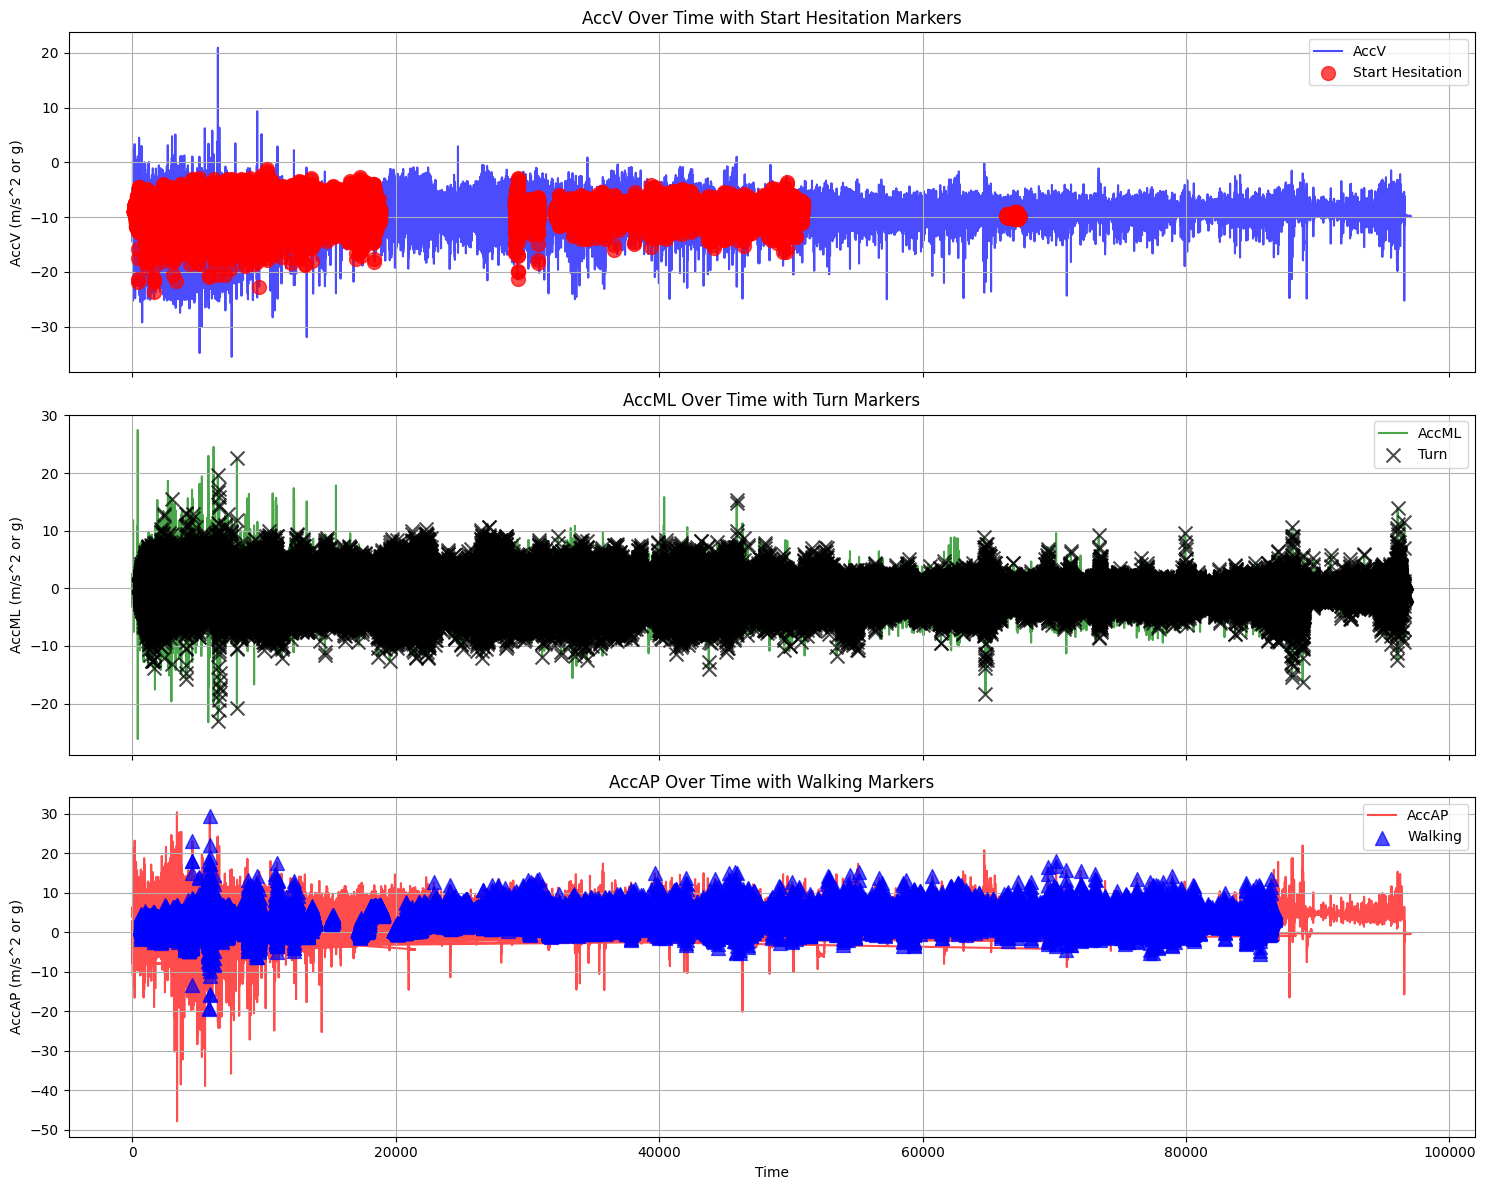

In [5]:


# Set the figure size and create 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot AccV over time with Start Hesitation markers on top
axs[0].plot(filtered_tdcsfog_data['Time'], filtered_tdcsfog_data['AccV'], label='AccV', color='b', alpha=0.7, zorder=1)
hesitation_points = filtered_tdcsfog_data[filtered_tdcsfog_data['StartHesitation'] == 1]
axs[0].scatter(hesitation_points['Time'], hesitation_points['AccV'], label='Start Hesitation', color='red', marker='o', s=100, alpha=0.7, zorder=2)
axs[0].set_title('AccV Over Time with Start Hesitation Markers')
axs[0].set_ylabel('AccV (m/s^2 or g)')
axs[0].legend()
axs[0].grid()

# Plot AccML over time with Turn markers on top
axs[1].plot(filtered_tdcsfog_data['Time'], filtered_tdcsfog_data['AccML'], label='AccML', color='g', alpha=0.7, zorder=1)
turn_points = filtered_tdcsfog_data[filtered_tdcsfog_data['Turn'] == 1]
axs[1].scatter(turn_points['Time'], turn_points['AccML'], label='Turn', color='black', marker='x', s=100, alpha=0.7, zorder=2)
axs[1].set_title('AccML Over Time with Turn Markers')
axs[1].set_ylabel('AccML (m/s^2 or g)')
axs[1].legend()
axs[1].grid()

# Plot AccAP over time with Walking markers on top
axs[2].plot(filtered_tdcsfog_data['Time'], filtered_tdcsfog_data['AccAP'], label='AccAP', color='r', alpha=0.7, zorder=1)
walking_points = filtered_tdcsfog_data[filtered_tdcsfog_data['Walking'] == 1]
axs[2].scatter(walking_points['Time'], walking_points['AccAP'], label='Walking', color='blue', marker='^', s=100, alpha=0.7, zorder=2)
axs[2].set_title('AccAP Over Time with Walking Markers')
axs[2].set_ylabel('AccAP (m/s^2 or g)')
axs[2].set_xlabel('Time')
axs[2].legend()
axs[2].grid()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Event Occurrences in the Filtered Data

This analysis counts the occurrences of three specific events (`Start Hesitation`, `Turn`, and `Walking`) in the filtered tdcsfog data:

- **Start Hesitation:** Total number of start hesitation events in the dataset.
- **Turn:** Total number of turn events in the dataset.
- **Walking:** Total number of walking events in the dataset.

The bar chart visualizes the total count of each event type, providing a quick overview of how frequently each event occurs in the filtered dataset.


StartHesitation     304790
Turn               1678782
Walking             207838
dtype: int64


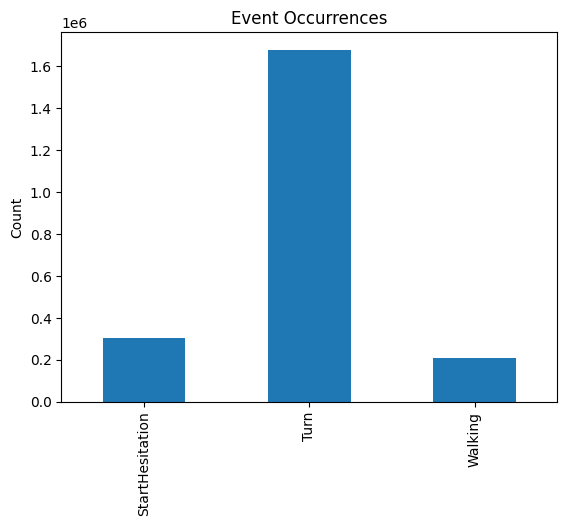

In [6]:
# Count occurrences of each event
event_counts = filtered_tdcsfog_data[['StartHesitation', 'Turn', 'Walking']].sum()
print(event_counts)

# Plot event occurrences
event_counts.plot(kind='bar', title='Event Occurrences')
plt.ylabel('Count')
plt.show()


# Correlation Matrix of Selected Features

This correlation matrix shows the relationships between the acceleration features (`AccV`, `AccML`, `AccAP`) and event markers (`Start Hesitation`, `Turn`, `Walking`). The values range from -1 to 1:

- **1** indicates a perfect positive correlation.
- **-1** indicates a perfect negative correlation.
- **0** indicates no correlation.

The heatmap visualizes these correlations, where stronger positive correlations are shown in warm colors and negative correlations in cool colors. This helps to understand how different acceleration signals relate to the occurrence of specific events in the data.


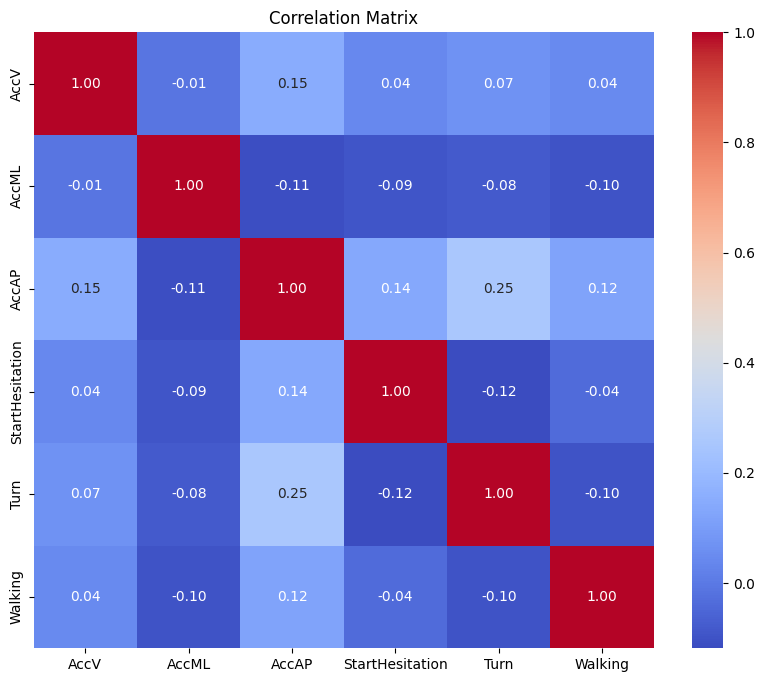

In [7]:
# Calculate the correlation matrix
correlation_matrix = filtered_tdcsfog_data[['AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking']].corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


## Average Accelerations During Events

This table shows the average acceleration values (`AccV`, `AccML`, `AccAP`) grouped by the presence of `Start Hesitation`, `Turn`, and `Walking` events. The averages are calculated for each unique combination of these events, providing insight into how acceleration patterns differ during different types of movement events:

- **Start Hesitation**: Occurs when the subject experiences difficulty initiating movement.
- **Turn**: Represents turning movements.
- **Walking**: Indicates continuous walking movement.

This analysis helps to identify specific acceleration characteristics associated with each type of event.


In [8]:
# Calculate average accelerations during StartHesitation, Turn, and Walking events
avg_acceleration_events = filtered_tdcsfog_data.groupby(['StartHesitation', 'Turn', 'Walking'])[['AccV', 'AccML', 'AccAP']].mean()
print(avg_acceleration_events)


                                  AccV     AccML     AccAP
StartHesitation Turn Walking                              
0               0    0       -9.377374 -0.072221  1.291131
                     1       -9.030334 -0.916942  3.392059
                1    0       -9.173478 -0.385071  2.849162
1               0    0       -9.090517 -0.762946  3.266044


# FEATURE ENGINEERING
In this section, we enhance our dataset by creating rolling features, calculating the acceleration magnitude, and introducing event counts over a specified window size. The following transformations are applied:

1. **Rolling Features**: For each acceleration component (`AccV`, `AccML`, and `AccAP`), we compute:
   - Rolling mean: Provides a smoothed version of the acceleration values over the specified window.
   - Rolling standard deviation: Indicates the variability of acceleration values within the window.

2. **Acceleration Magnitude**: The total acceleration magnitude is calculated by taking the sums of squares of `AccV`, `AccML`, and `AccAP` and finding their square root.
   This gives a comprehensive view of the overall acceleration at any given time.

3. **Event Counts**: We count the occurrences of `StartHesitation`, `Turn`, and `Walking` events over the rolling window, providing insights into the frequency of these events within the defined timeframe.

4. **Time Features**: We create sine and cosine transformations of the `Time` variable, which can help capture cyclical patterns in time-related data.

The resulting DataFrame now includes these additional features, which may improve the performance of any subsequent modeling efforts by providing more context to the movement data.


In [9]:
# Create rolling features
window_size = 5

# Calculate rolling mean and standard deviation
filtered_tdcsfog_data['Rolling_AccV_Mean'] = filtered_tdcsfog_data['AccV'].rolling(window=window_size).mean()
filtered_tdcsfog_data['Rolling_AccV_Std'] = filtered_tdcsfog_data['AccV'].rolling(window=window_size).std()
filtered_tdcsfog_data['Rolling_AccML_Mean'] = filtered_tdcsfog_data['AccML'].rolling(window=window_size).mean()
filtered_tdcsfog_data['Rolling_AccML_Std'] = filtered_tdcsfog_data['AccML'].rolling(window=window_size).std()
filtered_tdcsfog_data['Rolling_AccAP_Mean'] = filtered_tdcsfog_data['AccAP'].rolling(window=window_size).mean()
filtered_tdcsfog_data['Rolling_AccAP_Std'] = filtered_tdcsfog_data['AccAP'].rolling(window=window_size).std()

# Calculate acceleration magnitude
filtered_tdcsfog_data['Acc_Magnitude'] = np.sqrt(filtered_tdcsfog_data['AccV']**2 +
                                                filtered_tdcsfog_data['AccML']**2 +
                                                filtered_tdcsfog_data['AccAP']**2)

# Count events over the window size
filtered_tdcsfog_data['StartHesitation_Count'] = filtered_tdcsfog_data['StartHesitation'].rolling(window=window_size).sum()
filtered_tdcsfog_data['Turn_Count'] = filtered_tdcsfog_data['Turn'].rolling(window=window_size).sum()
filtered_tdcsfog_data['Walking_Count'] = filtered_tdcsfog_data['Walking'].rolling(window=window_size).sum()

# Create time features
filtered_tdcsfog_data['Time_Sin'] = np.sin(2 * np.pi * filtered_tdcsfog_data['Time'] / filtered_tdcsfog_data['Time'].max())
filtered_tdcsfog_data['Time_Cos'] = np.cos(2 * np.pi * filtered_tdcsfog_data['Time'] / filtered_tdcsfog_data['Time'].max())

# Display the updated DataFrame
print(filtered_tdcsfog_data.head())


   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking  \
0     0 -9.533939  0.566322 -1.413525                0     0        0   
1     1 -9.536140  0.564137 -1.440621                0     0        0   
2     2 -9.529345  0.561765 -1.429332                0     0        0   
3     3 -9.531239  0.564227 -1.415490                0     0        0   
4     4 -9.540825  0.561854 -1.429471                0     0        0   

   Rolling_AccV_Mean  Rolling_AccV_Std  Rolling_AccML_Mean  Rolling_AccML_Std  \
0                NaN               NaN                 NaN                NaN   
1                NaN               NaN                 NaN                NaN   
2                NaN               NaN                 NaN                NaN   
3                NaN               NaN                 NaN                NaN   
4          -9.534298          0.004472            0.563661           0.001903   

   Rolling_AccAP_Mean  Rolling_AccAP_Std  Acc_Magnitude  \
0              

# Handling Missing Values

In this section, we address the presence of NaN (Not a Number) values in our dataset. Missing values can significantly impact data analysis and machine learning model performance, so it's essential to handle them appropriately. Here, we demonstrate two common strategies:

1. **Filling NaN Values with Zeros**: This method replaces all NaN values in the DataFrame with 0. While this can be suitable in certain contexts, it may not always be the best approach, especially if zero does not represent a meaningful value for the missing data.

   ```python
   filtered_tdcsfog_data_filled = filtered_tdcsfog_data.fillna(0)


In [10]:
# Fill NaN values with 0
filtered_tdcsfog_data_filled = filtered_tdcsfog_data.fillna(0)


# Memory Optimization Function

In data analysis and machine learning, managing memory usage is crucial, especially when dealing with large datasets. The following function helps reduce the memory footprint of a DataFrame by converting data types to more memory-efficient formats. This approach not only saves memory but can also improve performance during processing.

## Function: `reduce_memory_usage`

This function iterates through each column in the DataFrame and adjusts its data type based on its range of values. Here's how it works:

1. **Identify Column Data Type**: For each column, the function checks if the data type is not an object (which typically means it's numeric).
  
2. **Calculate Minimum and Maximum Values**: It computes the minimum (`c_min`) and maximum (`c_max`) values of the column to determine the appropriate data type.

3. **Convert Integer Columns**: 
   - If the column is of integer type, it checks whether the values can fit into smaller integer types (`int8`, `int16`, or `int32`). If so, it converts the column to the smallest appropriate type.

4. **Convert Float Columns**: If the column contains floating-point numbers, it converts the data type to `float32`, which uses less memory than the default `float64`.

In [11]:

# Function to reduce memory usage by converting data types
def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if pd.api.types.is_integer_dtype(df[col]):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.float32)
    return df

## Data Preparation with Dask

In order to efficiently handle large datasets, we utilize Dask, a parallel computing library that allows for out-of-core computation and simplifies working with big data. Below are the steps taken to prepare our dataset using Dask.

### Step 1: Convert Pandas DataFrame to Dask DataFrame

We begin by converting our filled Pandas DataFrame into a Dask DataFrame with a specified number of partitions (in this case, 10). This allows us to perform computations in parallel, improving performance on large datasets.

### Step 2: Reduce Memory Usage

The function `reduce_memory_usage` is applied to each partition of the Dask DataFrame. This optimizes the data types in the DataFrame to save memory, especially useful when handling large datasets.

### Step 3: Fill NaN Values

We fill any missing values in the Dask DataFrame without loading the entire dataset into memory. This is crucial for maintaining performance and efficiency.

### Step 4: Feature Scaling

Feature scaling is performed using the `MinMaxScaler`, which is applied in a delayed computation manner to the Dask DataFrame. This step ensures that our features are on the same scale, facilitating better performance during modeling.

After applying the scaling, we compute the results to obtain a Dask DataFrame containing the scaled features.

Finally, we convert the scaled features to `float32` for further processing.

In [13]:
# Convert the Pandas DataFrame into a Dask DataFrame (with 10 partitions)
dask_df = dd.from_pandas(filtered_tdcsfog_data_filled, npartitions=10)

# Reduce memory usage by changing data types (applies to Dask DataFrame)
dask_df = dask_df.map_partitions(reduce_memory_usage)

# Fill NaN values in the Dask DataFrame without loading everything into memory
dask_df_filled = dask_df.fillna(dask_df.mean())

# Feature scaling using Dask (delayed computation)
scaler = MinMaxScaler()
scaled_features = dask_df_filled.map_partitions(lambda df: pd.DataFrame(scaler.fit_transform(df), columns=df.columns))

# Compute the scaled features to a Dask DataFrame
scaled_features = scaled_features.compute()

# Convert the dataset to float32
scaled_features = scaled_features.astype(np.float32)

C:\Users\Rahul\AppData\Local\Temp\ipykernel_27948\2863233545.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int32)
C:\Users\Rahul\AppData\Local\Temp\ipykernel_27948\2863233545.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int32)
C:\Users\Rahul\AppData\Local\Temp\ipykernel_27948\2863233545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

# Training the Model

In this section, we construct and train a Multi-Layer Perceptron (MLP) model to predict multiple target variables: `StartHesitation`, `Turn`, and `Walking`.

### Step 1: Define Target Columns

We specify the target columns that the model will predict, which are extracted from the filled Dask DataFrame and converted to a NumPy array of type `float32`.

### Step 2: Train-Test Split

The dataset is split into training and testing sets using an 80-20 ratio. This allows us to evaluate the model's performance on unseen data after training.

### Step 3: Calculate Class Weights

To tackle class imbalance in the target variables, class weights are calculated. This ensures that the model pays appropriate attention to underrepresented classes during training.

### Step 4: Build the MLP Model

We define a function `build_model` that constructs a simple MLP model with customizable activation functions and optimizers. The model consists of:

- An input layer with 256 neurons.
- Two hidden layers with 128 and 64 neurons, respectively.
- An output layer with three neurons (one for each target), using the sigmoid activation function.

The model is compiled with the specified optimizer and a binary cross-entropy loss function, which is suitable for multi-label classification tasks.

### Step 5: Model Configuration

The activation function and optimizer have been optimized by trying different parameters and running the model. The final layer uses sigmoid as the activation function as there is more than 2 target variables.
### Step 6: Train the Model

The model is trained using the `fit` method, with validation on the test set. We specify a batch size and number of epochs, and apply class weights to address any imbalance during training.

### Step 7: Model Summary

Finally, we display the model summary, which provides an overview of the layers and parameters in the MLP model.


In [14]:
# Target columns
targets = ['StartHesitation', 'Turn', 'Walking']
target_data = dask_df_filled[targets].compute().values.astype(np.float32)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target_data, test_size=0.2, random_state=42)

# Calculate class weights to address class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.argmax(axis=1)),
    y=y_train.argmax(axis=1)
)

# Convert class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Function to build a simple MLP model with customizable activation and optimizer
def build_model(activation_function='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(256, activation=activation_function, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(64, activation=activation_function))
    model.add(Dense(len(targets), activation='sigmoid'))  # Output layer for 3 targets

    # Compile the model with specified optimizer
    if optimizer == 'adam':
        opt = Adam()
    elif optimizer == 'sgd':
        opt = SGD()
    elif optimizer == 'rmsprop':
        opt = RMSprop()
    else:
        raise ValueError(f"Optimizer '{optimizer}' is not recognized.")

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

activation_function = 'tanh'  # Change to 'relu', 'tanh','sigmoid', elu, LeakyRelu. for testing
optimizer = 'sgd'  # Change to 'adam','sgd', 'rmsprop', etc. for testing

# Build the model
model = build_model(activation_function=activation_function, optimizer=optimizer)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict  # Apply class weights for handling imbalance
)

# Model summary
model.summary()

C:\Users\Rahul\AppData\Local\Temp\ipykernel_27948\2863233545.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int32)
C:\Users\Rahul\AppData\Local\Temp\ipykernel_27948\2863233545.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int32)
C:\Users\Rahul\AppData\Local\Temp\ipykernel_27948\2863233545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Epoch 1/30
88284/88284 ━━━━━━━━━━━━━━━━━━━━ 84s 938us/step - accuracy: 0.4294 - loss: 0.0128 - val_accuracy: 0.3539 - val_loss: 3.2349e-04
Epoch 2/30
88284/88284 ━━━━━━━━━━━━━━━━━━━━ 81s 916us/step - accuracy: 0.3795 - loss: 1.8060e-04 - val_accuracy: 0.4120 - val_loss: 1.5771e-04
Epoch 3/30
88284/88284 ━━━━━━━━━━━━━━━━━━━━ 81s 917us/step - accuracy: 0.4181 - loss: 9.8496e-05 - val_accuracy: 0.5154 - val_loss: 1.0330e-04
Epoch 4/30
88284/88284 ━━━━━━━━━━━━━━━━━━━━ 82s 928us/step - accuracy: 0.5333 - loss: 6.7403e-05 - val_accuracy: 0.5928 - val_loss: 7.7386e-05
Epoch 5/30
88284/88284 ━━━━━━━━━━━━━━━━━━━━ 141s 918us/step - accuracy: 0.6243 - loss: 5.1173e-05 - val_accuracy: 0.5731 - val_loss: 6.2280e-05
Epoch 6/30
88284/88284 ━━━━━━━━━━━━━━━━━━━━ 81s 912us/step - accuracy: 0.6058 - loss: 4.2009e-05 - val_accuracy: 0.6915 - val_loss: 5.1826e-05
Epoch 7/30
88284/88284 ━━━━━━━━━━━━━━━━━━━━ 80s 905us/step - accuracy: 0.7102 - loss: 3.4994e-05 - val_accuracy: 0.7068 - val_loss: 4.4771e-05
Ep

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,469 (181.52 KB)

 Trainable params: 46,467 (181.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Visualizing Model Performance

In this section, we visualize the training process of our Multi-Layer Perceptron (MLP) model by plotting the training and validation loss and accuracy over epochs.

### Step 1: Plotting Training and Validation Loss

We create a plot to compare the loss of the training and validation datasets over the epochs. This helps us to observe how well the model is learning and whether it might be overfitting. 

- **Training Loss**: Represents how well the model fits the training data.
- **Validation Loss**: Indicates how well the model performs on unseen data (validation set).

### Step 2: Plotting Training and Validation Accuracy

We also plot the training and validation accuracy to assess the model's performance. This visualization allows us to see how accurately the model is predicting the target labels over time.

- **Training Accuracy**: Shows the accuracy of the model on the training data.
- **Validation Accuracy**: Reflects the accuracy of the model on the validation dataset.

These plots provide insights into the model's training dynamics, helping us to identify potential issues such as overfitting or underfitting, and guiding further model adjustments.


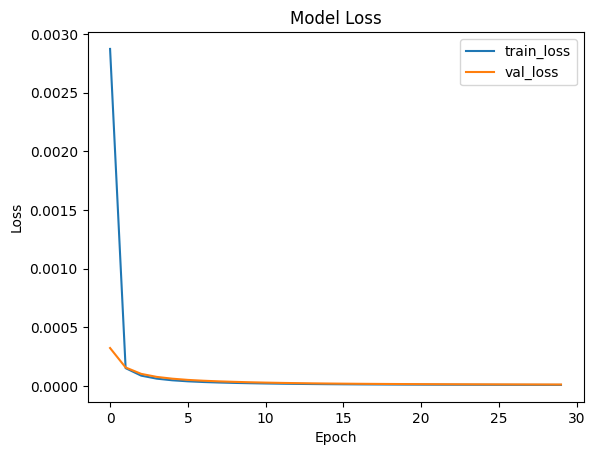

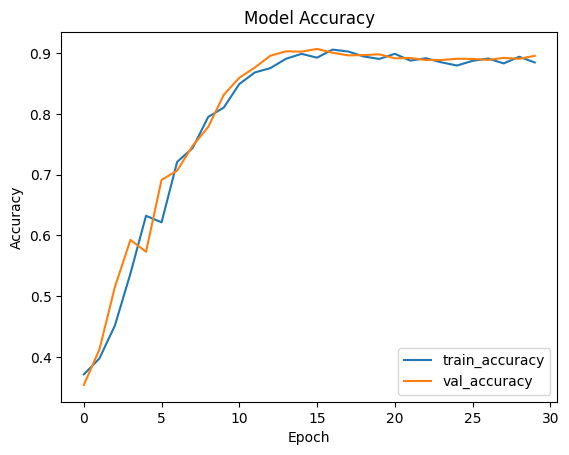

In [15]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluating Model Performance

After training the model, it's crucial to evaluate its performance using appropriate metrics. This section covers how to generate predictions, create confusion matrices, and analyze the classification reports for each target label.

## Predicting Probabilities

First, we predict the probabilities for the test set. Since our model outputs probabilities for each class, we need to binarize these predictions based on a chosen threshold (commonly 0.5).

44142/44142 ━━━━━━━━━━━━━━━━━━━━ 34s 757us/step
Confusion Matrix for StartHesitation:


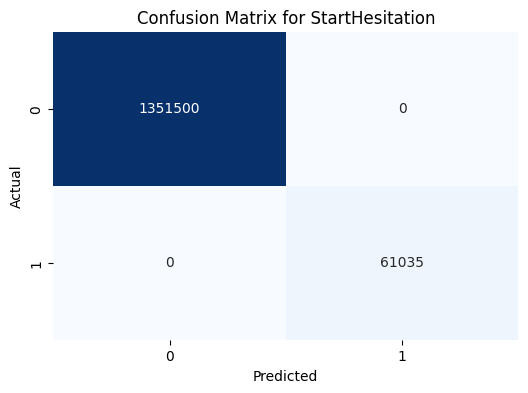

Classification Report for StartHesitation:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00   1351500
     Class 1       1.00      1.00      1.00     61035

    accuracy                           1.00   1412535
   macro avg       1.00      1.00      1.00   1412535
weighted avg       1.00      1.00      1.00   1412535

Confusion Matrix for Turn:


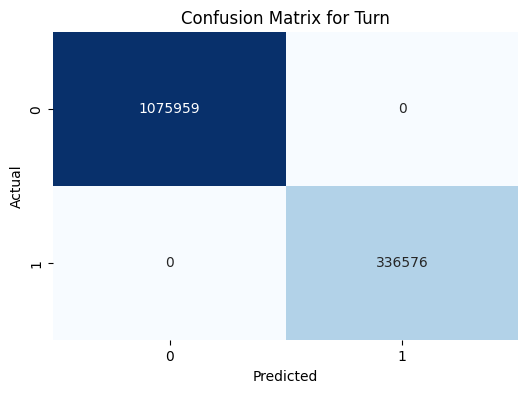

Classification Report for Turn:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00   1075959
     Class 1       1.00      1.00      1.00    336576

    accuracy                           1.00   1412535
   macro avg       1.00      1.00      1.00   1412535
weighted avg       1.00      1.00      1.00   1412535

Confusion Matrix for Walking:


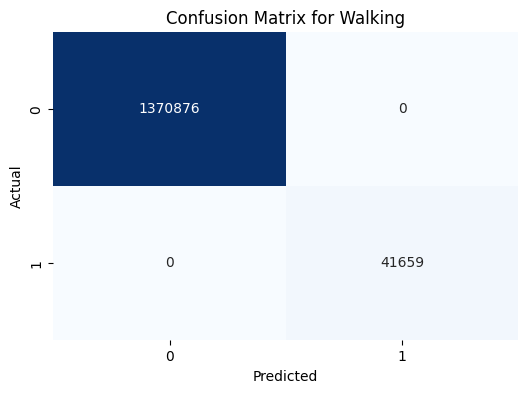

Classification Report for Walking:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00   1370876
     Class 1       1.00      1.00      1.00     41659

    accuracy                           1.00   1412535
   macro avg       1.00      1.00      1.00   1412535
weighted avg       1.00      1.00      1.00   1412535



In [16]:

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)

# Binarize the predictions (convert probabilities to 0 or 1 based on a threshold of 0.5)
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate confusion matrix for each target label
for i, target in enumerate(targets):
    print(f"Confusion Matrix for {target}:")
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    
    # Display the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {target}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print classification report (Precision, Recall, F1-Score)
    print(f"Classification Report for {target}:\n")
    print(classification_report(y_test[:, i], y_pred[:, i], target_names=['Class 0', 'Class 1']))

SAVING THE MODEL

In [17]:
from keras.models import load_model

# Save the trained model
model.save('my_model2.h5')
